<a href="https://colab.research.google.com/github/jieunjeon/Data-Science-Fundamental/blob/master/Exploration/EXP03_Face_Detection_and_Landmark_Crown_on_Head.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Let's Build a Camera-Sticker App!
## Goal of this project
- Get familiar with: `openCV`
- Try concepts of: video processing, detection, keypoint estimation, tracking, camera perspective
- Build a Camera app that is robust at distance changes and angles


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


## Prepare an Image data

I am going to use my fav K-pop idol, Jeong Se-woon's 셀카.    
Image ref: https://twitter.com/jeongsewoon_twt/status/1101775665311834113?lang=bg

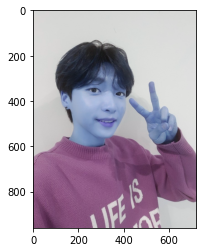

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

my_image_path = '/content/drive/MyDrive/aiffel/EXP_3_data/image.png';
img_bgr = cv2.imread(my_image_path)    # Read image with OpenCV
img_bgr = cv2.resize(img_bgr, (720, 960))    # Resize to 640x360의 
img_show = img_bgr.copy()      # store a copy of the image
plt.imshow(img_bgr)
plt.show()

But it looks a bit strange. The picture looks good, but the color is a bit odd.   
Why is the color of your face so blue?
This is due to the **nature of opencv**. The image libraries such as matplotlib and dlib use **image channels in RGB **(red, green, blue) order.   
So that the image's red is changed to blue and blue is changed to red.   
if you want to output the image handled in opencv using another image library, you will need to do the color correction as follows.

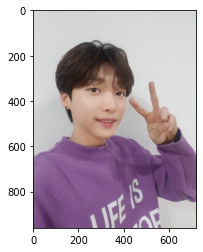

In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

Good to see his handsome face again ;) 


# Face Detection
I will use `dlib`'s `HOG` (Histogram of Oriented Gradient) feature and SVM to find slidiing window of the face.   
Ref for the concept of `HOG`: https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78

Since dlib receives rgb image as input, cvtColor() was used to convert opencv's bgr image to rgb.

The second parameter to detector_hog is the number of image pyramids. Increasing the size of an image through an upsampling method is called an `image pyramid`.   
Re-detection of faces in the image pyramid allows for more accurate detection because smaller faces can be viewed larger.
Ref for the `image pyramids`: https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html

In [ ]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   # initialize detector


In [ ]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(170, 241) (491, 562)]]


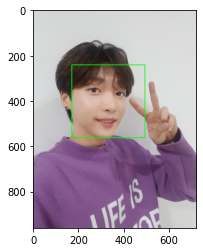

In [ ]:
print(dlib_rects)   # coordinates of the face found

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# Face Landmark Localization (이목구비 위치 추론)
## Object keypoint estimation Algorithm
Object keypoint estimation is a technique for finding a point inside an object, such as a face landmark. Algorithms for finding keypoints are divided into two main categories.

1) **top-down**: find the bounding box and predict the keypoint inside the box

2) **Bottom-up**: First find the keypoints of the entire image and create a box by clustering them using the point relationship

I will use the first category, and useDlib provided model with the weight file they provide.

Dlib provides a pretrained model trained on the ibug 300-W dataset. The learning algorithm used an ensemble model of the regression tree.    
Refer to the paper One Millisecond Face Alignment with an Ensemble of Regression Trees published in CVPR (Computer Vision and Pattern Recognition) in 2014. It's okay if you don't understand algorithms today.   
Ref to the article: https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf

In [ ]:
!wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
!mv shape_predictor_68_face_landmarks.dat.bz2 /content/drive/MyDrive/aiffel/EXP_3_data

--2021-07-20 03:00:32--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  22.6MB/s    in 2.7s    

2021-07-20 03:00:35 (22.6 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
!bzip2 -d /content/drive/MyDrive/aiffel/EXP_3_data/shape_predictor_68_face_landmarks.dat.bz2

In [ ]:
model_path = '/content/drive/MyDrive/aiffel/EXP_3_data/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

`landmark_predictor` takes an `RGB image` and `dlib.rectangle` as input and returns `dlib.full_object_detection` .

In [ ]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


Since points are an object of dlib.full_object_detection, individual locations can be accessed with the `parts()` function. I converted it so that it can be accessed in a more intuitive (x, y) form. So list_points is a list of 68 tuples (x, y). If you repeat for every number of faces found in the image, 68 landmarks are stored in list_landmark as many as the number of faces.

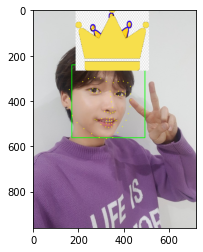

In [56]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.clf()
plt.imshow(img_show_rgb)
plt.show()
plt.close()

Nice, I can see the white dots are all around the points, eyebrow, eyes, noes, mouse, and chin.   
Let's prepare the crown image and put it on.   

1. The position of the sticker   
$x = x_{nose}$   
$y = y_{nose} - width/2$   
   
2. The size of the sticker   
$width = height = width_{bbox}$

Let's check the coordinates first.

In [ ]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(348, 428)
(x,y) : (348,267)
(w,h) : (322,322)


The center coordinates of the nose is `(348, 428)`   
Then let's read the crown image and resize it based on the above calculated size

In [ ]:
sticker_path = '/content/drive/MyDrive/aiffel/EXP_3_data/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(322, 322, 3)


Edit the (x,y) coordinates to add this crown sticker image to the original image. The start point is the top-left.

In [ ]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (187,-55)


We got the negative value on the y-value, this means that the crown image is cropped at the top.   
Let's crop the crown image by

In [ ]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(267, 322, 3)


set the y corrdinates of the top to the image's boundary.

In [ ]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (187,0)


Apply the sticker to the original image

In [ ]:
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

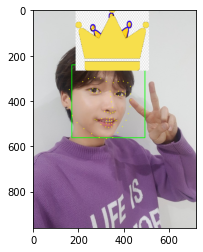

In [57]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [52]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

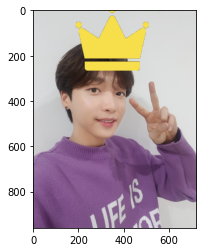

In [58]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# References
- handling imaage: https://opencv-python.readthedocs.io/en/latest/doc/01.imageStart/imageStart.html
- HOG, Modern Face Recognition with Deep Learning: https://medium.com/@ageitgey/machine-learning-is-fun-part-4-modern-face-recognition-with-deep-learning-c3cffc121d78
- CVPR article 'One Millisecond Face Alignment with an Ensemble of Regression Trees': https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf
